In [1]:
import numpy as np 
from scipy.signal import firwin, freqz, freqs
import matplotlib.pyplot as plt 
import scipy
import librosa
from scipy.io import wavfile
from numba import njit
import seaborn as sns
import pandas as pd

In [2]:
M = np.loadtxt("mario.txt", delimiter=",")

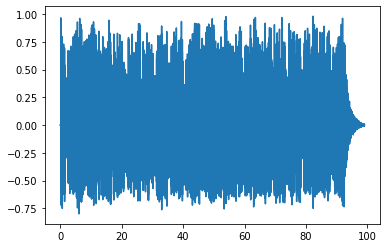

In [3]:
t = M[:,0]
x = M[:,1]
plt.plot(t,x); # x = tutti minori di 1 in modulo, per questo vanno moltiplicati per 2^qualcosa (ad es. 8)

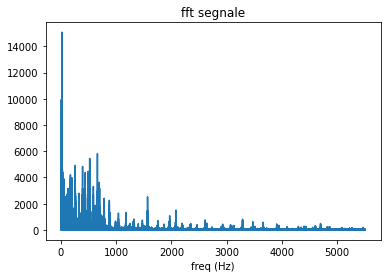

In [4]:
a = np.abs(np.fft.fft(x))
a = a[0:len(a)//2]
f = np.linspace(0,11025//2,len(a))
plt.plot(f,a);
plt.xlabel("freq (Hz)");
plt.title("fft segnale");

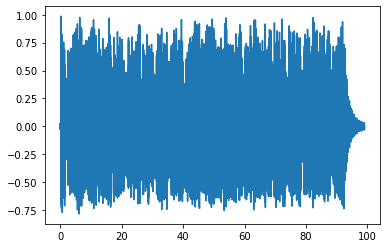

In [5]:
xc = x + 2.5e-2*np.sin(2*np.pi*1500*t)
plt.plot(t,xc);

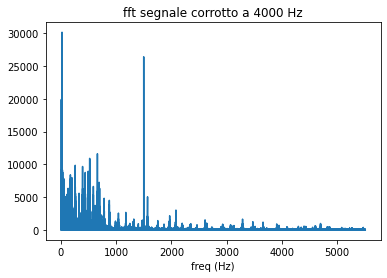

In [6]:
a = np.abs(np.fft.fft(xc))
a = 2*a[0:len(a)//2]
f = np.linspace(0,11025//2,len(a))
plt.plot(f,a);
plt.xlabel("freq (Hz)");
plt.title("fft segnale corrotto a 4000 Hz");

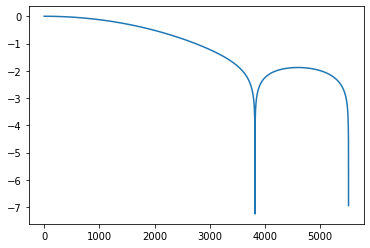

In [10]:
N_taps = 8
fs = 11025
fc = 1500 - 500 # meglio scendere un po', ma occhio ad essere troppo aggressivo sulla regione intorno a 5000 Hz
coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass")
#coeffs
[w,h] = freqz(coeffs, worN=len(x))
w *= (fs/2)/np.pi # di default w è normalizzato all'intervallo [0,pi]; lo mappo a [0,fnyq] (vedi documentazione freqz)
h = np.log10(np.abs(h)) # abs perché è complesso, log10 perché si usano i dB
plt.plot(w,h);

In [21]:
ciao = np.fft.fftfreq(len(x), 1/fs) #fftfreq è come un linspace ma del tipo [metà positiva, metà negativa] delle frequenze. Basterebbe prendere solo la prima metà ma per curiosità controllo fftshift
k = np.fft.fftshift(ciao) # fftshift fa in modo che si abbia [metà negativa, metà positiva] esattamente come si farebbe nel caso di un plot
k.shape[0]//2
ind = np.nonzero(k == 0)[0]
ind = ind[0]
#print(ind)
k = k[ind:]
#k.shape
np.allclose(f,k, atol=1e-5, rtol = 1e-3) 

True

In [11]:
# FILTRO CONVOLUZIONALE CON 0 PADDING INIZIALE

# uno zero padding di N_taps-1 all'inizio e alla fine permette di sapere dove tagliare per togliere la munnizza (?)
N = N_taps
# per ora basta mettere 
y = np.hstack((np.zeros((7,)),xc)) # 7 è N-1
#y.shape[0]-7 == x.shape[0]

output = np.zeros((y.shape[0],))

for n in range(7,len(output)) : # i primi 7 (= N-1) elementi (da 0 a 6) sono solo uno zero padding
    for i in range(N) :
        output[n] += coeffs[i]*y[n-i]

output = output[8:] # tolgo i primi 7 valori fasulli

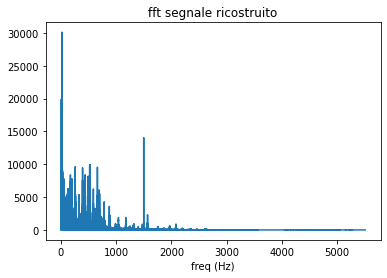

In [12]:
a = np.abs(np.fft.fft(output))
a = 2*a[0:len(a)//2]
f = np.linspace(0,11025//2,len(a))
plt.plot(f,a);
plt.xlabel("freq (Hz)");
plt.title("fft segnale ricostruito");

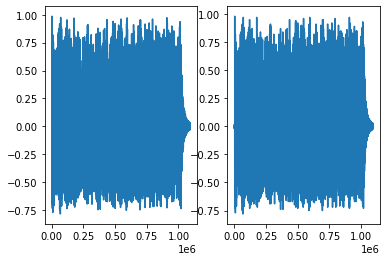

In [13]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(y);
ax[1].plot((y*100).astype(int)/100);
# y.max() è 1 e qualcosa, così diventa 100 e qualcosa (che elimino con int) (entro 2^7, ok); quando ridivido (stavolta a float) riottengo lo stesso numero di partenza ma con solo 2 cifre decimali - quindi l'approssimazione fatta è tale per cui i nostri numeri sono gli stessi di prima a meno di un fattore O(10^-3)

## SOMMARE UNA COSTANTE AIUTEREBBE AD AVERE UN VETTORE POSITIVO E QUINDI 0 NECESSITà DEL SEGNO E QUINDI UN BIT LIBERO IN PIù E QUINDI PIù RISOLUZIONE

In [14]:
# Variante ad interi

# FILTRO CONVOLUZIONALE CON 0 PADDING INIZIALE

# uno zero padding di N_taps-1 all'inizio e alla fine permette di sapere dove tagliare per togliere la munnizza (?)
N = N_taps
# per ora basta mettere 
coeffs_int = (100*coeffs).astype(int)
y_int = np.hstack((np.zeros((7,)),100*xc)).astype(int) # 7 è N-1
#y.shape[0]-7 == x.shape[0]

output_int = np.zeros((y_int.shape[0],), dtype=int)

for n in range(7,len(output)) : # i primi 7 (= N-1) elementi (da 0 a 6) sono solo uno zero padding
    for i in range(N) :
        output_int[n] += int(coeffs_int[i]*y_int[n-i])

output_int = output_int[8:] # tolgo i primi 7 valori fasulli

In [22]:
(coeffs*467).astype(int) # fc = 1000

array([  4,  23,  76, 127, 127,  76,  23,   4])

In [23]:
print("la differenza media fra i vettori di output usando tutte/solo 2 cifre decimali è in percentuale:",100*np.abs((output - output_int/100).mean()))

la differenza media fra i vettori di output usando tutte/solo 2 cifre decimali è in percentuale: 0.3155774125476443


In [24]:
@njit
def fir_int(input, coeffs_int, Nt) :
    output_int = np.zeros(input.shape[0])
    for n in range(7, len(output_int)) :
        for i in range(Nt) :
            output_int[n] += int(coeffs_int[i]*input[n-i])
    return output_int

@njit
def fir_float(input, coeffs, Nt) :
    output_float = np.zeros(input.shape[0])
    for n in range(7, len(output_float)) :
        for i in range(Nt) :
            output_float[n] += coeffs[i]*input[n-i]
    return output_float

In [25]:
# qui metto una simulazione completa di quello che dovrebbe avvenire nella fpga

# Variante ad interi tagliati opportunamente. Fattore dei coefficienti: 278 (per restare entro 127 come valore max), fattore dei dati: 127 (idem, xc.max() è dell'ordine dell'unità)
k_coeff = 467
k_data = 127
# FILTRO CONVOLUZIONALE CON 0 PADDING INIZIALE

# uno zero padding di N_taps-1 all'inizio e alla fine permette di sapere dove tagliare per togliere la munnizza (?)
N = 8#N_taps
# per ora basta mettere 
coeffs_int = (k_coeff*coeffs).astype(int)
y_int = np.hstack((np.zeros((7,)),k_data*xc)).astype(int) # 7 è N-1
#y.shape[0]-7 == x.shape[0]

# output_int = np.zeros((y_int.shape[0],), dtype=int)

# for n in range(7,len(output_int)) : # i primi 7 (= N-1) elementi (da 0 a 6) sono solo uno zero padding
#     for i in range(N) :
#         output_int[n] += int(coeffs_int[i]*y_int[n-i])
output_int = fir_int(y_int, coeffs_int, N)

output_int = output_int[8:] # tolgo i primi 7 valori fasulli

output_int /= k_coeff
output_int /= k_data
print(output_int)

y_float = np.hstack((np.zeros((7,)),k_data*xc))
output_float = fir_float(y_float, coeffs, N)
output_float = output_float[8:]/k_data
print(output_float)

# df = pd.DataFrame({"float":output_float, "int": output_int})
# sns.lineplot(data=df, palette="tab10", linewidth=2.5)

[ 0.00013489  0.00097793  0.00379369 ...  0.00660945  0.00284948
 -0.00556408]
[ 0.0002003   0.0012263   0.00451612 ...  0.00932792  0.00503598
 -0.00493584]


In [26]:
with open("input.txt","w") as fh :
    np.savetxt(fh, xc*k_data)

In [27]:
print(coeffs_int)

[  4  23  76 127 127  76  23   4]


In [65]:
c = int("0b"+str(1000111111100000000), 2)
bin(int(k_coeff*k_data*output_int.max()))

'0b1000010011011101'

In [77]:
l = ["1"] + ["0"] * 18
for i in range(9,16) :
    l[-i] = "1"

s = "0b" + "".join(l)
b = int(s,2)
#print(b == c)
#print(b)
int(2e4) & b

# meglio recuperare il primo bit separatamente..!

19968

In [133]:
print(bin(b)[2:])
#print(4*"0" + bin(20000)[2:])
#print(4*"0" + bin(20000 & b)[2:])
#print(20000 & b)
print(bin(c)[2:])
print(20000 & c)
print(20000 & (c - 2**18) + ()*2**18)

1000111111100000000
0000100111000100000
0000100111000000000
19968
1000111111100000000
19968


In [134]:
print(20000 & (c - 2**19))

19968


average difference between float vs int: 0.004520009106466214


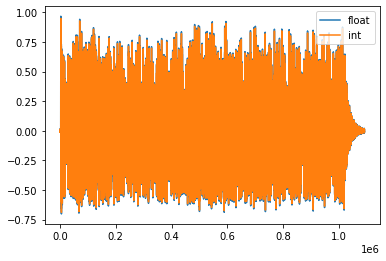

In [28]:
plt.plot(output_float, label = "float");
plt.plot(output_int, label = "int");
plt.legend(loc = "upper right");
print("average difference between float vs int:",(np.abs(output_float - output_int)).mean())

In [162]:
def find_b(bin) :
    l = ["0"] * 19 #["1"] + ["0"] * 18
    for i in range(bin, (bin+7)) :
        l[-i] = "1"

    s = "0b" + "".join(l)
    b = int(s,2)
    return b

# #@njit
# def fir_int_approx(input, coeffs, Nt, b) :
#     output_int_approx = np.zeros(input.shape[0], dtype=int)
#     for n in range(7, len(output_int_approx)) :
#         for i in range(Nt) :
#             output_int_approx[n] += int(coeffs[i]*input[n-i]) 
#     for i in range(len(output_int_approx)) :
#         output_int_approx[i] = (output_int_approx[i] & b) >> (19-8)
#     return output_int_approx

def fir_int_approx(input, coeffs, Nt, b) :
    output_int_approx = fir_int(input, coeffs, Nt)
    for i in range(len(output_int_approx)) :
        output_int_approx[i] = ((int(output_int_approx[i]) >> 8) & (2**7-1)) + (int(output_int_approx[i]) & 2**18)*2**7
        #output_int_approx[i] = ((int(output_int_approx[i]) & b) >> 8)+ (int(output_int_approx[i]) & 2**18)*2**7 #aggiungo il primo bit del numero tutto a sinistra sommando bit*2**8. Estraggo questo bit con un altro and
    return output_int_approx

In [161]:
bin(2**7)[2:]

'10000000'

In [153]:
len(bin(2**8)[2:])

9

In [168]:
a = int(output_int[-1]*k_coeff*k_data)
a
#print(bin(a)[3:])

-134

In [163]:
lb = [find_b(i) for i in range(1,12)] # da 1 a 11 vanno bene (contando da 1 visto che uso l[-1])

output_int_approx = fir_int_approx(y_int, coeffs_int, N, find_b(9))

output_int_approx = output_int_approx[8:] # tolgo i primi 7 valori fasulli

output_int_approx = output_int_approx / (k_coeff*k_data) #* 2**11
# for i in range(len(output_int_approx)) :
#     output_int_approx[i] = int(output_int_approx[i]) << 11

print(output_int_approx)

[  0.         950.39253951   0.         ... 950.39253951   0.
 950.39253951]


average difference between float vs int: 955.6815923093807


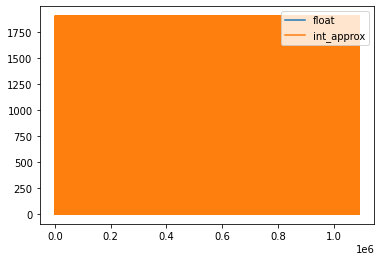

In [141]:
plt.plot(output_float, label = "float");
plt.plot(output_int_approx, label = "int_approx");
plt.legend(loc = "upper right");
print("average difference between float vs int:",(np.abs(output_float - output_int_approx)).mean())

In [ ]:
def distance_from_float(bin_list) :
    

# Altre cose

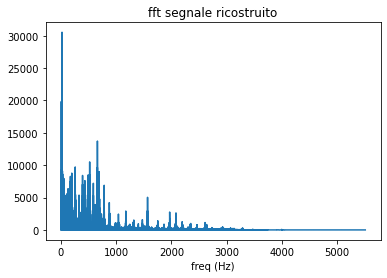

In [24]:
# da funzionizzare al variare di N!
N_taps = 25
fs = 11025
fc = 4000 - 1000 # meglio scendere un po'
coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass")

# uno zero padding di N_taps-1 all'inizio e alla fine permette di sapere dove tagliare per togliere la munnizza (?)
N = N_taps
# per ora basta mettere 
y = np.hstack((np.zeros((7,)),xc)) # 7 è N-1
#y.shape[0]-7 == x.shape[0]

output = np.zeros((y.shape[0],))

for n in range(7,len(output)) : # i primi 7 (= N-1) elementi sono solo uno zero padding
    for i in range(N) :
        output[n] += coeffs[i]*y[n-i]

a = np.abs(np.fft.fft(output))
a = 2*a[0:len(a)//2]
f = np.linspace(0,11025//2,len(a))
plt.plot(f,a);
plt.xlabel("freq (Hz)");
plt.title("fft segnale ricostruito");

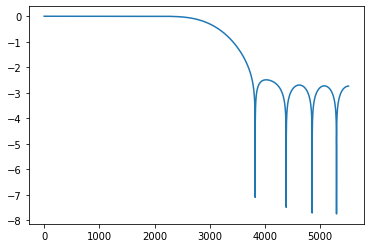

In [27]:
N_taps = 25
fs = 11025
fc = 4000 - 1000 # meglio scendere un po', ma occhio ad essere troppo aggressivo sulla regione intorno a 5000 Hz
coeffs = firwin(numtaps=N_taps, cutoff=fc, fs=fs, pass_zero="lowpass")
#coeffs
[w,h] = freqz(coeffs, worN=len(x))
w *= (fs/2)/np.pi # di default w è normalizzato all'intervallo [0,pi]; lo mappo a [0,fnyq] (vedi documentazione freqz)
h = np.log10(np.abs(h)) # abs perché è complesso, log10 perché si usano i dB
plt.plot(w,h);